In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 8

ts = pd.read_csv("assignment.csv", parse_dates=['date'], index_col="date")
ts = ts.sort_index()

# Change column names. We don't want blanks in column names.
# Create new python list for new column names
column_names = ['daily_worker_count']

# Assign newly created column names list to dataframe columns
ts.columns = column_names

ts_pd_sr = ts['daily_worker_count']

In [47]:
log_ts_pd_sr = np.log(ts_pd_sr)
log_ts_pd_sr_diff = log_ts_pd_sr - log_ts_pd_sr.shift()
log_ts_pd_sr_diff2 = log_ts_pd_sr_diff - log_ts_pd_sr_diff.shift()
log_ts_pd_sr_diff3 = log_ts_pd_sr_diff2 - log_ts_pd_sr_diff2.shift()

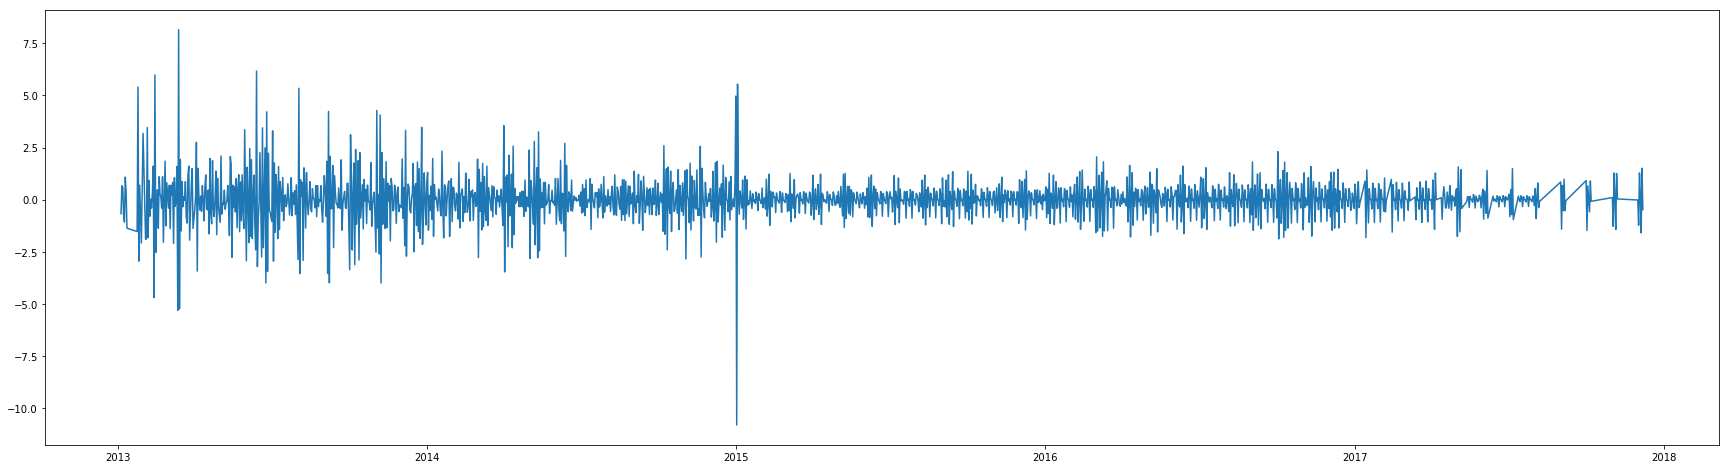

In [48]:
plt.plot(log_ts_pd_sr_diff3)

In [53]:
log_ts_pd_sr_diff3.dropna(inplace=True)

In [54]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=7)
    rolstd = pd.rolling_std(timeseries, window=7)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\Users\toshiba\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
C:\Users\toshiba\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()


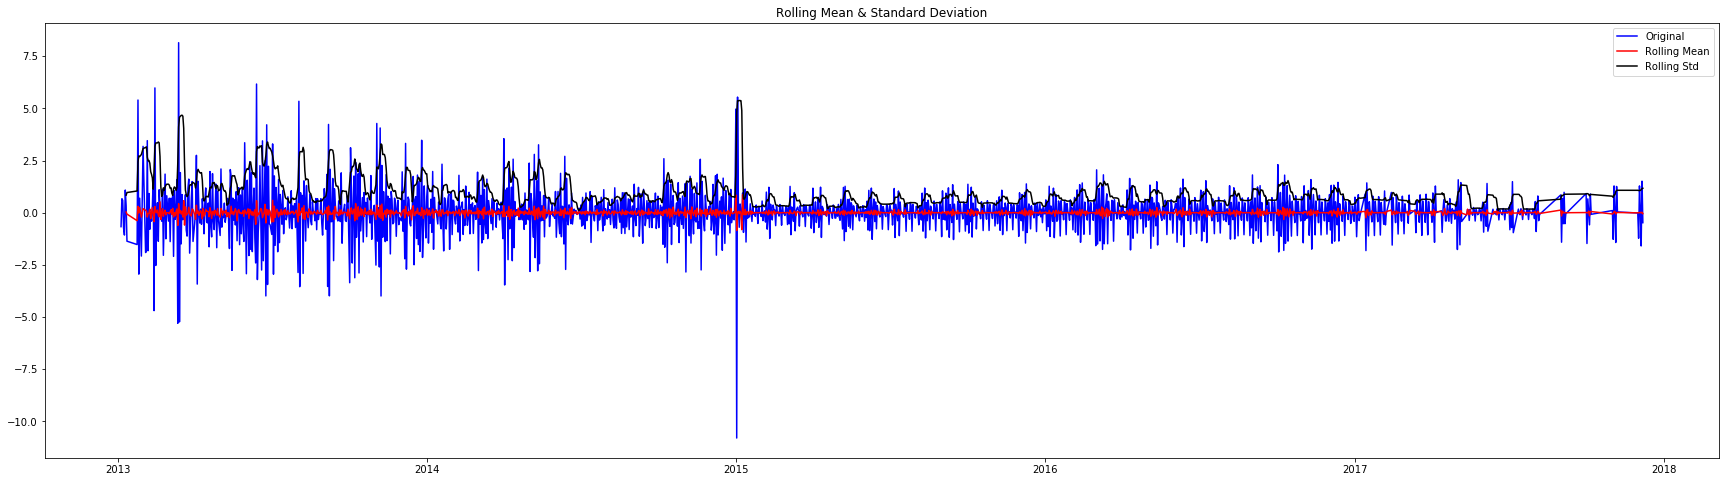

Results of Dickey-Fuller Test:
Test Statistic                  -22.306507
p-value                           0.000000
#Lags Used                       23.000000
Number of Observations Used    1620.000000
Critical Value (1%)              -3.434393
Critical Value (5%)              -2.863326
Critical Value (10%)             -2.567721
dtype: float64


In [55]:
test_stationarity(log_ts_pd_sr_diff3)

In [67]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(log_ts_pd_sr_diff3.values, nlags = 20)
lag_pacf = pacf(log_ts_pd_sr_diff3.values, nlags = 20)

C:\Users\toshiba\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


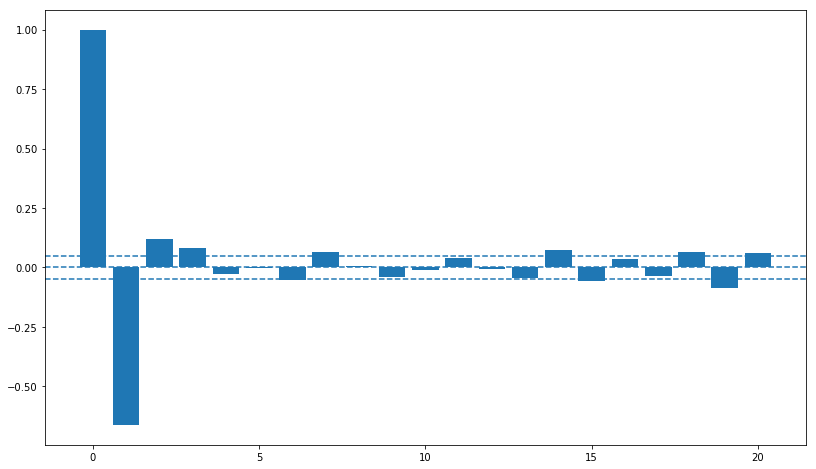

In [68]:
plt.subplot(121)
plt.bar(left=range(len(lag_acf)), height= lag_acf)
plt.axhline(y=0, linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_ts_pd_sr_diff3)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_ts_pd_sr_diff3)), linestyle='--')

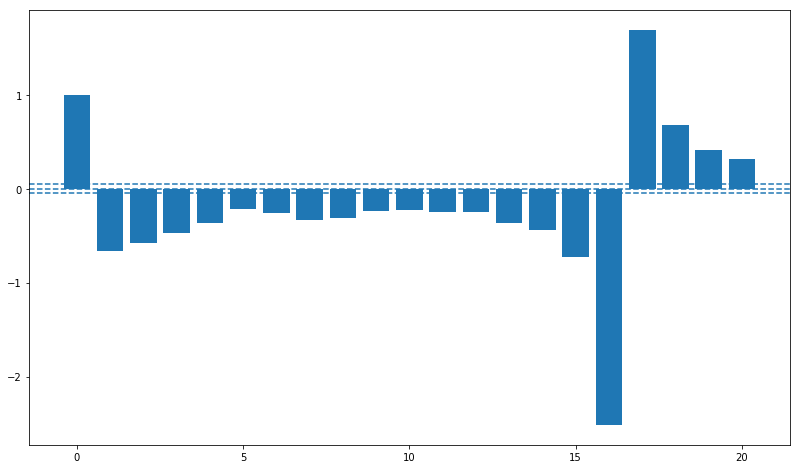

In [69]:
plt.subplot(121)
plt.bar(left=range(len(lag_pacf)), height= lag_pacf)
plt.axhline(y=0, linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_ts_pd_sr_diff3)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_ts_pd_sr_diff3)), linestyle='--')

In [70]:
from statsmodels.tsa.arima_model import ARIMA

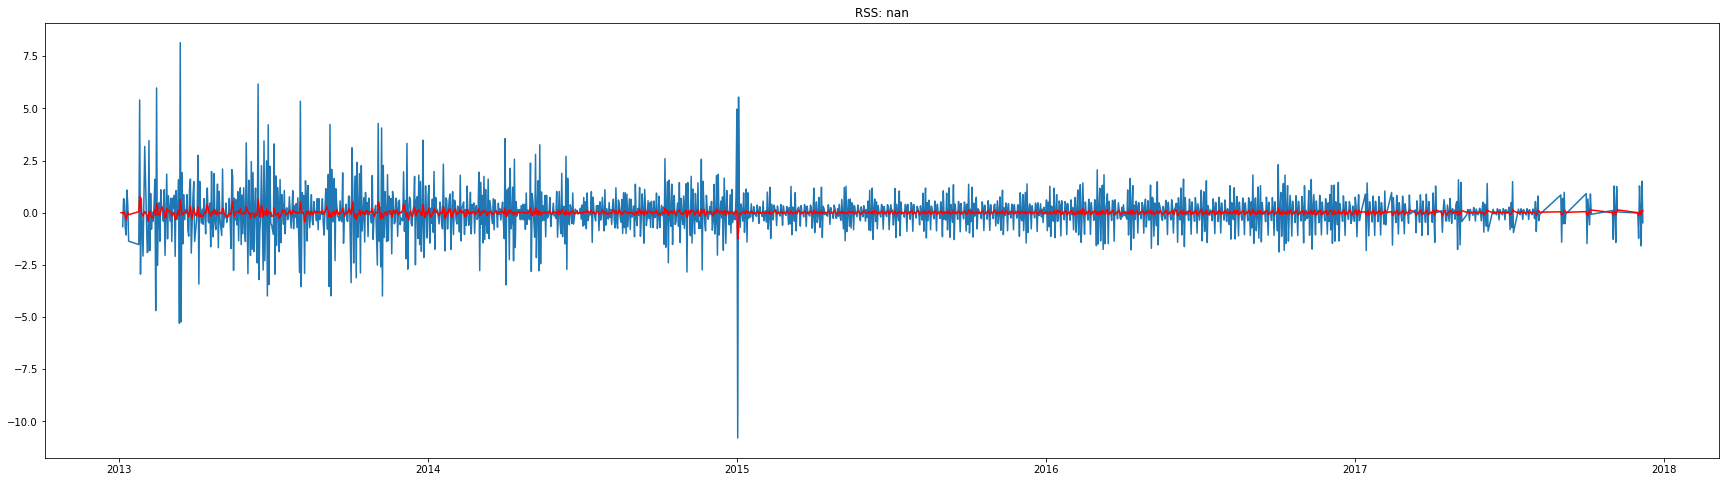

In [74]:
model = ARIMA(log_ts_pd_sr, order=(2,1,0))
results_AR = model.fit(disp=1)
plt.plot(log_ts_pd_sr_diff3)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - log_ts_pd_sr_diff3)**2))

In [75]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date
2013-01-03    0.004581
2013-01-04    0.005515
2013-01-05   -0.046680
2013-01-06    0.022317
2013-01-07    0.043671
dtype: float64

In [76]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head(20)

date
2013-01-03    0.004581
2013-01-04    0.010096
2013-01-05   -0.036584
2013-01-06   -0.014267
2013-01-07    0.029404
2013-01-08   -0.157191
2013-01-09   -0.498834
2013-01-10   -0.618860
2013-01-11   -0.596520
2013-01-12   -0.694404
2013-01-24   -0.644569
2013-01-25    0.144440
2013-01-26    0.642205
2013-01-27    0.648641
2013-01-29    0.490083
2013-01-31    0.545849
2013-02-03    0.406439
2013-02-04   -0.003921
2013-02-05    0.072320
2013-02-06    0.120829
dtype: float64

In [77]:
predictions_ARIMA_log = pd.Series(log_ts.iloc[0], index=log_ts.index)

In [78]:
predictions_ARIMA_log = pd.Series(log_ts.iloc[0], index=log_ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

date
2013-01-02    1.386294
2013-01-03    1.390875
2013-01-04    1.396391
2013-01-05    1.349710
2013-01-06    1.372027
dtype: float64

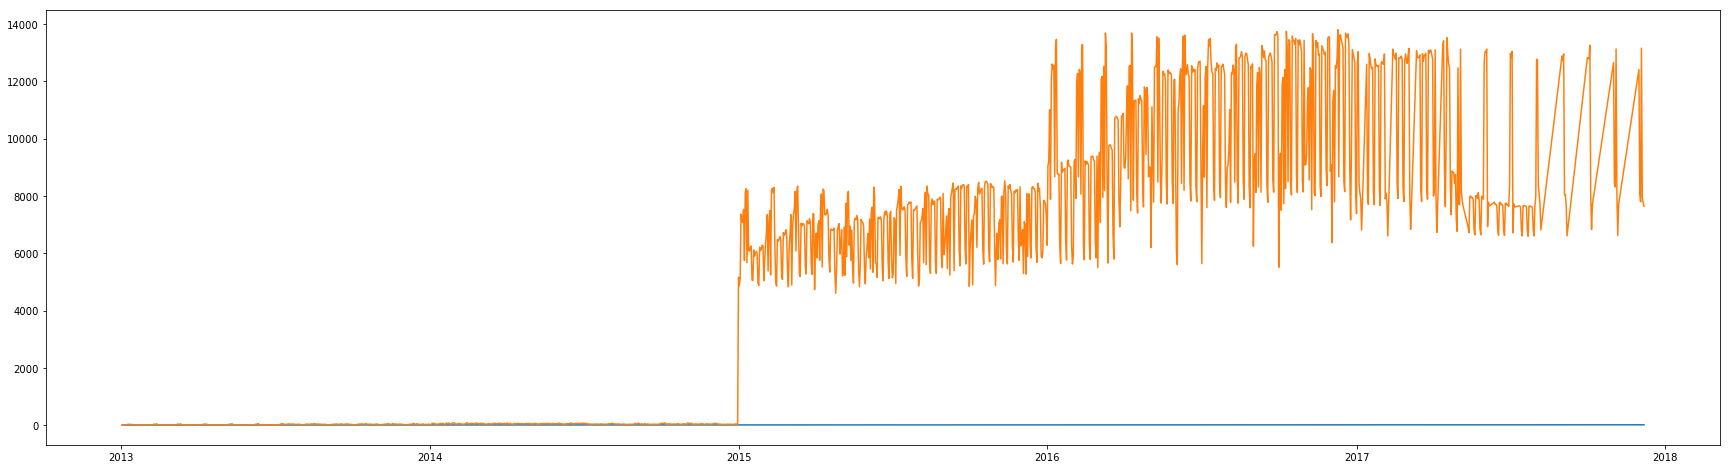

In [79]:
plt.plot(predictions_ARIMA_log)
plt.plot(ts)

In [ ]:
dataframe = pd.read_csv("assignment.csv", parse_dates=['date'], index_col="date")
dataframe = dataframe.sort_index()
dataframe['year'] = dataframe.index.year
dataframe['day_of_month'] = dataframe.index.day
dataframe['month'] = dataframe.index.month
dataframe['day_of_week'] = dataframe.index.dayofweek
dataframe['quarter'] = dataframe.index.quarter
dataframe['week_of_year'] = dataframe.index.weekofyear

is_weekend = []
for i in dataframe.day_of_week:
    if i >= 5:
        is_weekend.append(1)
    else:
        is_weekend.append(0)
        
dataframe['is_weekend'] = is_weekend